## **Libraries**

In [16]:
# Librerias fundamentales
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# Librerias de pytorch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
import torch

# Librerias auxiliares de sklearn
    # Divide el conjunto de datos en subconjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

    # Muestra la matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay

# Clases y funciones propias
    # Convierte el conjunto de datos en tensores
from dataset_trch import augmentation, images_ds, show_image

    # Crea el modelo
from model_trch import model_highlight

    # Entrena el modelo
from train_trch import model_train

    # Metricas para medir accuracy y matriz de confusión
from metrics_custom import accuracy_trch, confusion_trch

## **Dataset**

In [17]:
# Lee el excel de datos

# Divide los datos en clases para balancearlas
df_soft = pd.read_excel("images_data.xlsx", sheet_name = "soft")
df_nonsoft = pd.read_excel("images_data.xlsx", sheet_name = "non_soft")

# Balancea las clases
df_soft = df_soft.sample(n = 150)
df_nonsoft = df_nonsoft.sample(n = 150)

# Divide los datos en subconjuntos de entrenamiento y prueba
df_soft_train, df_soft_val, df_nonsoft_train, df_nonsoft_val = train_test_split(
    df_soft,
    df_nonsoft,
    test_size = 0.2
)

# Junta nuevamente las clases en subconjuntos de entrenamiento y prueba
df_train = pd.concat([df_soft_train, df_nonsoft_train]).sample(frac = 1).reset_index(drop=True)
df_val = pd.concat([df_soft_val, df_nonsoft_val]).reset_index(drop=True)


# Lee las imagenes y crea un objeto que obtiene todos los conjuntos de datos de entrenamiento (tiene aumento de datos)
dataset_train = images_ds(dataset = df_train,
                    file_path_col = "file_path",
                    highlight_col = "highlight_path", 
                    labels_col="soft_story", 
                    data_transform = augmentation,
                    data_augmentation = True,
                    mean_img = [0.5, 0.5, 0.5],
                    std_img = [0.5, 0.5, 0.5],
                    mean_high = [0.5, 0.5, 0],
                    std_high = [0.5, 0.5, 1.]
                    )

# Lee las imagenes y crea un objeto que obtiene todos los conjuntos de datos de prueba (no tiene aumento de datos)
dataset_val = images_ds(dataset = df_val,
                    file_path_col = "file_path",
                    highlight_col = "highlight_path", 
                    labels_col="soft_story", 
                    data_transform = augmentation,
                    data_augmentation = False,
                    mean_img = [0.5, 0.5, 0.5],
                    std_img = [0.5, 0.5, 0.5],
                    mean_high = [0.5, 0.5, 0],
                    std_high = [0.5, 0.5, 1.]
                    )

# Carga las imagenes para ser utilizadas para entrenamiento por batches
train_loader = DataLoader(dataset = dataset_train, batch_size = 16, shuffle = True)
val_loader = DataLoader(dataset = dataset_val, batch_size = dataset_val.len, shuffle = True)

<PIL.Image.Image image mode=RGB size=256x256 at 0x2AB95942870>


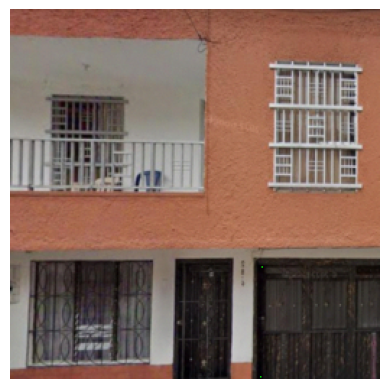

<PIL.Image.Image image mode=RGB size=256x256 at 0x2AB95951D00>


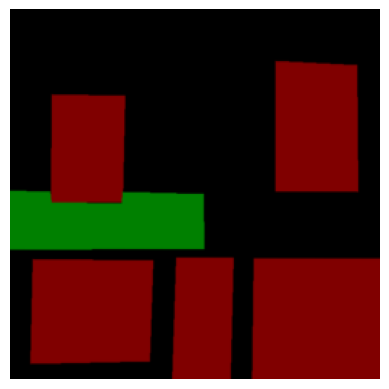

In [18]:
showing = dataset_train[0][0]
show_image(showing, mean = dataset_train.mean_img, std = dataset_train.std_img)
show_image(showing, highlight = True, mean = dataset_train.mean_high, std = dataset_train.std_high)

## **Hyperparmeter tunning**

In [19]:
def hyperparmeter_function(lr, probability, max_metric):
    print(f'-----Learning rate: {lr} | Dropout rate: {probability}-----')
# se crea el modelo con 2 capa de 128 perceptrones
    model = model_highlight(channels_in = 5,
                    out_conv = 1024*5*5,
                    hidden_layers = [128, 64],
                    probability = probability
                    )

# se toma como función de pérdida, la función de entropía cruzada
    criterion = nn.BCELoss()

# se utiliza el optimizador Adam evitando entrenar los parámetros del modelo preentrenado
    optimizer = optim.Adam(model.parameters(),
                           lr = lr,
                           weight_decay = 0.001
                           )

    metrics = model_train(
        epochs = 30,
        model = model,
        train_loader = train_loader,
        val_loader = val_loader,
        optimizer = optimizer,
        loss_function = criterion,
        metric = accuracy_trch
    )

    max_acc = np.max(metrics["val_accuracy"])

    max_index = np.max(np.where(metrics["val_accuracy"] == max_acc))

    delta_loss = np.mean(np.abs(metrics["val_loss"][5:max_index+1] - metrics["train_loss"][5:max_index+1]))

    if max_acc - delta_loss > max_metric:
        torch.save(model.state_dict(), "saved_models/best_random_search.pth")

    return lr, probability, max_acc, delta_loss

## **Random search**

In [20]:
# se definen todas la variables del entrenamiento
max_metric = 0

dataframe = pd.DataFrame({
    'lr':[],
    'prob':[],
    'max_acc':[],
    'delta_loss':[]
})

for i in range(25):

    random_lr = random.random()
    random_prob = random.random()
    lr = 10**-(1+random_lr*4)
    probability = random_prob*0.3

    lr, probability, max_acc, delta_loss = hyperparmeter_function(lr = lr, probability = probability, max_metric = max_metric)

    row = pd.DataFrame({
        'lr':[lr],
        'prob':[probability],
        'max_acc':[max_acc],
        'delta_loss':[delta_loss]
    })

    dataframe = pd.concat([dataframe, row], ignore_index = True)

    if max_acc - delta_loss > max_metric:
        max_metric = max_acc - delta_loss

dataframe.to_csv("random_search.csv", index = False)

-----Learning rate: 0.07364523756335341 | Dropout rate: 0.01884239550735094-----
Epoch [1/30] | Train Loss: 0.84 | Train Accuracy: 0.55 | Validation Loss: 4.13 | Validation Accuracy: 0.52
Epoch [2/30] | Train Loss: 0.71 | Train Accuracy: 0.52 | Validation Loss: 0.69 | Validation Accuracy: 0.50
Epoch [3/30] | Train Loss: 0.67 | Train Accuracy: 0.61 | Validation Loss: 0.69 | Validation Accuracy: 0.50
Epoch [4/30] | Train Loss: 0.68 | Train Accuracy: 0.60 | Validation Loss: 0.69 | Validation Accuracy: 0.50
Epoch [5/30] | Train Loss: 0.68 | Train Accuracy: 0.51 | Validation Loss: 0.69 | Validation Accuracy: 0.50
Epoch [6/30] | Train Loss: 0.68 | Train Accuracy: 0.57 | Validation Loss: 0.66 | Validation Accuracy: 0.58
Epoch [7/30] | Train Loss: 0.66 | Train Accuracy: 0.61 | Validation Loss: 0.73 | Validation Accuracy: 0.53
Epoch [8/30] | Train Loss: 0.62 | Train Accuracy: 0.72 | Validation Loss: 10.34 | Validation Accuracy: 0.50
Epoch [9/30] | Train Loss: 0.68 | Train Accuracy: 0.57 | Valid